# Architecture

* Lab runs Experiment with a ExperimentConfig which contains all possible values for every single variable we want to tune.
* Each Experiment contains a Pipeline, which follows the basic ML steps like data -> preprocessor -> training -> testing
* Data in our case are text files stored on disk.
* Some intermediate data on disk like BPE outputs from the preprocessor could be needed.

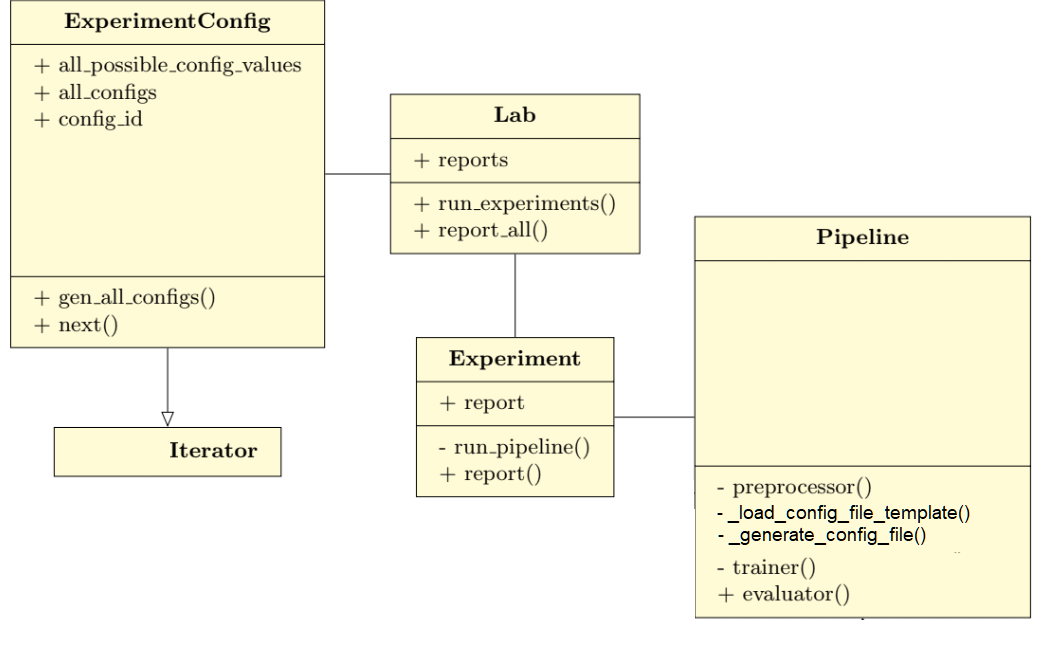

# Setup

In [88]:
ROOT_DATA_DIR = "data/"
CONFIG_FILE_TEMPLATE_PATH = "config_template.yaml"

In [89]:
import os.path
from pathlib import Path
from urllib.request import urlretrieve
import subprocess
import gzip
import shutil
import tarfile
import re
import random
import collections
import itertools
import gc

import pandas as pd
from tabulate import tabulate
import numpy as np

# For user feedback
from tqdm import tqdm
import matplotlib.pyplot as plt


# Experiment Config

In [90]:
class ExperimentConfig( collections.abc.Iterator ):
    """ An Iterator that will iterates over all possible combination of configs, some config can be fixed.
        Have a default dict of all_possible_config_values mapping each config name to a list of states.
        IN: 
            freeze_configs (dict): a dict containing the name of the config to be fixed 
                                and the index of the state to use from the corresponding list.
        DO NOT MODIFY!!
    """
    def __init__( self, possible_config_values, perc = 1.0, freeze_configs = {}, must_include_combinations = {} ):
        self.config_id = -1
        self.current_config = None
        self.all_possible_config_values = possible_config_values
        self.all_configs = []
        self.gen_all_configs()
        self.config_samples = []
        self.sample_configs( perc, freeze_configs, must_include_combinations )
        self._deduplicate_samples()

    def gen_all_configs( self ):
        self.all_configs = [
            dict( zip( self.all_possible_config_values.keys(), values ) ) 
                for values in itertools.product( *self.all_possible_config_values.values() )
        ]
        
    def _filter_frozen_configs( self, freeze_configs ):
        ## freeze_setting data structure constraint
        for freeze_setting in freeze_configs:
            if( 
                isinstance( freeze_configs[ freeze_setting ], collections.abc.Sequence ) 
                and not isinstance( freeze_configs[ freeze_setting ], (str, bytes, bytearray) )
            ):
                raise ValueError( "A freeze setting value cannot be a collection!" )
        frozen_samples = []
        for config in self.all_configs:
            valid_config = True
            for setting in config: # Check if all settings are correctly freezing
                setting_value = config[ setting ]
                if setting in freeze_configs:
                    if setting_value != freeze_configs[ setting ]:
                        valid_config = False
            if valid_config:
                frozen_samples.append( config )
        return frozen_samples
        
    def sample_configs( self, perc, freeze_configs = {}, must_include_combinations = {} ):
        """Sample down the all possible combinations of configs to only test a few
            freeze_configs: dictionary of {setting name: setting value}
            must_include_combinations: dictionary of {setting name: list of values that must be included in at least one sample}
        """
        ## must_include_combinations data structure constraint
        for must_include_setting in must_include_combinations:
            if not isinstance( must_include_combinations[ must_include_setting ], list ):
                raise ValueError( "All must include setting values must be lists!" )
        ## Check so all setting values in freeze_configs are included in must_include_combinations.
        if len( freeze_configs ) > 0 and len( must_include_combinations ) > 0:
            for freeze_setting in freeze_configs:
                if freeze_setting in must_include_combinations:
                    if freeze_configs[ freeze_setting ] not in  must_include_combinations[ freeze_setting ]:
                        raise ValueError( "All freeze setting value must be included in must include configs!" )
        frozen_samples = self._filter_frozen_configs( freeze_configs )
        
        ## Random sampling by percentage
        for config in frozen_samples:
            rand = random.uniform( 0, 1 )
            if rand < perc:
                self.config_samples.append( config )
                
        ## Artificially add all samples in the must include combinations
        for must_have_comb in (
            dict( zip( must_include_combinations.keys(), values ) ) 
                for values in itertools.product( *must_include_combinations.values() )
        ):
            if( len( must_have_comb ) == 0 ):
                break # Stop the loop when must have is empty [{}]
            current_frozen_configs = self._filter_frozen_configs( must_have_comb )
            if len( current_frozen_configs ) > 0:
                current_must_have_config = random.choice( current_frozen_configs )
                self.config_samples.append( current_must_have_config )
        ##TODO: deduplicate configs
        return self.config_samples

    def get_df_config_samples( self ):
        if len( self.config_samples ) == 0:
            return None
        else:
            df_configs = pd.DataFrame( self.config_samples )
            df_configs = df_configs.set_index( list( df_configs.columns ) ).sort_index()
            return df_configs

    def _deduplicate_samples( self ):
        df_samples = self.get_df_config_samples()
        self.config_samples = df_samples.reset_index().drop_duplicates().to_dict( "records" )
        
    def __iter__( self ):
        return self
        
    def __next__( self ):
        self.config_id += 1
        if( self.config_id >= len( self.config_samples ) ):
            raise StopIteration
        self.current_config = self.config_samples[ self.config_id ]
        return self.current_config


# Lab

In [91]:
class Lab():
    """
        DO NOT MODIFY!!
    """
    def __init__( self, possible_config_values, perc = 1.0, freeze_configs = {}, must_include_combinations = {} ):
        self.experiment_config = ExperimentConfig( 
            possible_config_values, 
            perc = perc, 
            freeze_configs = freeze_configs, 
            must_include_combinations = must_include_combinations 
        )
        self.reports = []

    def _add_report( self, config, result ):
        self.reports.append( (config, result) )
        
    def _run_experiment( self ):
        self.current_experiment = Experiment( self )
        test_acc = self.current_experiment.report()
        # gc.collect()
        # torch.cuda.empty_cache()
        self._add_report( self.experiment_config.current_config, test_acc )
        return( test_acc )
    
    def report_all( self ):
        for config in self.experiment_config:
            print( "================================ New experiment ================================" )
            setting_names = list( self.experiment_config.all_possible_config_values.keys() )
            for ii, setting in enumerate( config ):
                print( f"\t{setting_names[ ii ]}: " + str( config[ setting ] ) )
            test_acc = self._run_experiment()
            print( "Test acc:", test_acc )
        return( self.reports )

    def get_df_reports( self ):
        df_result = pd.DataFrame( 
            [
                list( 
                    [report[ 0 ][ key ] for key in report[ 0 ]]
                ) + [report[ 1 ]] 
                    for report in self.reports
            ]
        )
        df_result.columns = list( self.experiment_config.all_possible_config_values.keys() ) + ["test_acc"]
        df_result = df_result.set_index( list( df_result.columns[ :-1 ] ) ).sort_index()
        return( df_result )

# Experiment

In [92]:
class Experiment():
    """
        DO NOT MODIFY!!
    """
    def __init__( self, lab ):
        self.lab = lab
        self.current_pipeline = None 
        
    def _run_pipeline( self ):
        self.current_pipeline = Pipeline( self )
        return( self.current_pipeline.evaluator() )

    def plot_curves( self ):
        current_model = self.current_pipeline.model
        fig = plt.figure(figsize=(6, 4))
        ax = plt.subplot()
        ax.set_title("Plot of the (hopefully) decreasing loss over epochs")
        ax.plot(current_model.training_loss_, 'b-')
        ax.set_ylabel("Training Loss", color='b')
        ax.set_xlabel("Epoch")
        # ax.set_yscale('log')
        ax.tick_params(axis='y', labelcolor='b')
        ax = ax.twinx()
        ax.plot(current_model.training_accuracy_, 'r-')
        ax.set_ylabel("Accuracy [%]", color='r')
        ax.tick_params(axis='y', labelcolor='r')
        a = list(ax.axis())
        a[2] = 0
        a[3] = 100
        ax.axis(a)
        t = np.arange(0, len( current_model.training_accuracy_ ), len( self.current_pipeline.dataset_train )//self.current_pipeline.batch_size+1)
        ax.set_xticks(ticks=t)
        ax.set_xticklabels(labels=np.arange(len(t)))
        fig.tight_layout()
        plt.show()
        
    def report( self ):
        test_acc = self._run_pipeline()
        # if( self.lab.experiment_config.current_config[ "model_name" ] != "baseline" ): #LEGACY
        #     self.plot_curves()
        return( test_acc )

# Models

Should be taken cared of by ONMT.

# Main Pipeline

In [93]:
def custom_collate( input_samples ):
    """ A custom collate function for collating input tensors in batch together, used by the Dataloaders.    """
    targets_stack = torch.stack( [sample[ 0 ] for sample in input_samples] )
    ids_stack = torch.stack( [sample[ 1 ] for sample in input_samples] ) if input_samples[ 0 ][ 1 ] is not None else None
    masks_stack = torch.stack( [sample[ 2 ] for sample in input_samples] ) if input_samples[ 0 ][ 2 ] is not None else None
    ls_text = [sample[ 3 ] for sample in input_samples]
    batch_data = (targets_stack, ids_stack, masks_stack, ls_text)
    return batch_data

In [94]:
class Pipeline():
    def __init__( self, experiment ):
        self.experiment = experiment
        self.config = self.experiment.lab.experiment_config
        self.dataset_train = None
        self.dataset_test = None
        self.train_iterator = None
        self.test_iterator = None
        self.batch_size = 512
        self.tokenizer = None
        
        # self._prepare_tokenizer()
        self.model = None
        # self._prepare_model()
        # self._preprocessor()
        self._generate_config_file()
    def _load_config_file_template( self ):
        with open( CONFIG_FILE_TEMPLATE_PATH, 'r' ) as ff:
            return( ff.read() )
        
    def _generate_config_file( self ):
        tempalte_config_str = self._load_config_file_template()
        for key, val in self.config.current_config.items():
            # print( f"\t\tSubstituting config variable string {key} with {str( val )}" ) #DEBUG
            tempalte_config_str = re.sub( f"\\b{key}\\b", str( val ), tempalte_config_str )
            
        with open( 'test_model/current_config.yaml', 'w' ) as ff:
            ff.write( tempalte_config_str )

    def _prepare_tokenizer( self ): #LEGACY: may not need
        print( "_prepare_tokenizer( self )" )
        # if( self.config.current_config[ "model_name" ] != "baseline" ):
        #     self.tokenizer = AutoTokenizer.from_pretrained( self.config.current_config[ "model_name" ], model_max_length = 128 )

    def _prepare_model( self ):
        print( "Preparing model:", self.config.current_config )
        # if( self.config.current_config[ "model_name" ] == "baseline" ):
        #     self.model = self.config.current_config[ "model_name" ]
        # else:
        #     self.model = ...
            
    def _preprocessor( self ):
        """ Run bash preprocessor

        OUT: make DATA_PATH ready to use.
        """
        print( "Preprocessing..." )
        
    def _trainer( self ):
        # if( self.config.current_config[ "model_name" ] == "baseline" ):
        #     print( "Baseline model, training will be skipped." )
        #     return 0
        print( "Training..." )
        with open("ml_experiments.log", "w") as output_file:
            subprocess.run( 
                ["bash", "train_test_model.sh"],
                cwd = os.path.join( os.getcwd(), "test_model" ),
                stdout = output_file,
                stderr = output_file,
                text = True 
            )
        return( 0 )
        # self.model.train()
        # loss_function = nn.BCELoss() # A loss function that fits our choice of output layer and data. The
        # ...
        # return( max( self.model.training_accuracy_ ) )
        
    def _evaluator( self ):
        print( "_evaluator( self )" )
        
    def evaluator( self ):
        """ Evaluate and report/store scores
        """
        print( "Evaluator..." )
        self._preprocessor()
        max_training_acc = 0
        max_training_acc = self._trainer()
        # max_test_acc = self._evaluator()
        return( max_training_acc )

# Production Run

In [95]:
possible_config_values = {
    "DATASET_NAME_TRAIN": [
        "original", 
        # "bible", 
        # "all"
    ],
    "DATASET_NAME_VALID": [
        "original",
        # "bible", 
        # "all"
    ],
    "TRAIN_STEPS": [200*1000],
    "METRIC": ["BLEU"],
    "LEARNING_RATE": [0.001, 0.01, 0.05],
    "DECAY_METHOD": ["none", "noamwd", "rsqrt", "noam"],
    "ENC_LAYERS":[2, 4],
    "DEC_LAYERS":[2, 4],
    "HEADS":[4, 16],
    "HIDDEN_SIZE": [64],
    "WORD_VEC_SIZE": [64, 512], # should match HIDDEN_SIZE
    "TRANSFORMER_FF": [128, 2048],
    "DROPOUT": ["[0.2]"],
    "ATTENTION_DROPOUT": ["[0.2]"],
    
}
FREEZE_CONFIGS = {
    # "LEARNING_RATE": possible_config_values[ "LEARNING_RATE" ][ 0 ],
    # "DECAY_METHOD": possible_config_values[ "DECAY_METHOD" ][ 0 ],
    "ENC_LAYERS": possible_config_values[ "ENC_LAYERS" ][ 0 ],
    "DEC_LAYERS": possible_config_values[ "DEC_LAYERS" ][ 0 ],
    "HEADS": possible_config_values[ "HEADS" ][ 0 ],
    "HIDDEN_SIZE": possible_config_values[ "HIDDEN_SIZE" ][ 0 ],
    "WORD_VEC_SIZE": possible_config_values[ "WORD_VEC_SIZE" ][ 0 ],
    "TRANSFORMER_FF": possible_config_values[ "TRANSFORMER_FF" ][ 0 ],
}
MUST_INCLUDE_COMBINATIONS = {}

test_config = ExperimentConfig( 
    possible_config_values,
    perc = 1.0,
    freeze_configs = FREEZE_CONFIGS, 
    must_include_combinations = MUST_INCLUDE_COMBINATIONS
)

# print( tabulate( test_config.get_df_config_samples().reset_index(), headers='keys', tablefmt='psql' ) )

test_config.get_df_config_samples()

Empty DataFrame
Columns: []
Index: [(original, original, 200000, BLEU, 0.001, noam, 2, 2, 4, 64, 64, 128, [0.2], [0.2]), (original, original, 200000, BLEU, 0.001, noamwd, 2, 2, 4, 64, 64, 128, [0.2], [0.2]), (original, original, 200000, BLEU, 0.001, none, 2, 2, 4, 64, 64, 128, [0.2], [0.2]), (original, original, 200000, BLEU, 0.001, rsqrt, 2, 2, 4, 64, 64, 128, [0.2], [0.2]), (original, original, 200000, BLEU, 0.01, noam, 2, 2, 4, 64, 64, 128, [0.2], [0.2]), (original, original, 200000, BLEU, 0.01, noamwd, 2, 2, 4, 64, 64, 128, [0.2], [0.2]), (original, original, 200000, BLEU, 0.01, none, 2, 2, 4, 64, 64, 128, [0.2], [0.2]), (original, original, 200000, BLEU, 0.01, rsqrt, 2, 2, 4, 64, 64, 128, [0.2], [0.2]), (original, original, 200000, BLEU, 0.05, noam, 2, 2, 4, 64, 64, 128, [0.2], [0.2]), (original, original, 200000, BLEU, 0.05, noamwd, 2, 2, 4, 64, 64, 128, [0.2], [0.2]), (original, original, 200000, BLEU, 0.05, none, 2, 2, 4, 64, 64, 128, [0.2], [0.2]), (original, original, 200000, BLEU, 0.05, rsqrt, 2, 2, 4, 64, 64, 128, [0.2], [0.2])]

Here the main program will start to run and report all possible configs, the results can be seen in the final dataframe.

In [96]:
mt_lab = Lab( 
    possible_config_values,
    perc = 1.0,
    freeze_configs = FREEZE_CONFIGS, 
    must_include_combinations = MUST_INCLUDE_COMBINATIONS
)
lab_result = mt_lab.report_all()
mt_lab.get_df_reports()

================================ New experiment ================================
	DATASET_NAME_TRAIN: original
	DATASET_NAME_VALID: original
	TRAIN_STEPS: 200000
	METRIC: BLEU
	LEARNING_RATE: 0.001
	DECAY_METHOD: noam
	ENC_LAYERS: 2
	DEC_LAYERS: 2
	HEADS: 4
	HIDDEN_SIZE: 64
	WORD_VEC_SIZE: 64
	TRANSFORMER_FF: 128
	DROPOUT: [0.2]
	ATTENTION_DROPOUT: [0.2]
Evaluator...
Preprocessing...
Training...


KeyboardInterrupt: 